# CRM using Simpy

CRM system simulation using simpy. 

Company CRM populated with accounts (customer companies) and opportunities coming from time to time from these accounts and which can be bidded, won or lost by Company.

Principles: Account "agents" wich will go through a set of events, namely:
- inbound_mktg_event: account finds the contant and follows a CTA to be added into Company MQL list
- outbount_mkt_event: account reached by Company outbound marketing actions and follows a CTA to be added into Company MQL
- inbound_sales_event: account is identified as a sales qualified leads and converted into prospect
- outbound_sales_event: account reached out by Company sales representative and accepts call to become a prospect
and other similar events representing how an account moves from stage to stage through the sales funnel and sales process

Each event is the result of:
- the current phase where the account is 
- an adjustable random variable, using some paramaters (example, conversion rate for CTA, ...)

In [33]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import simpy

from eccore.ipython import nb_setup
from pathlib import Path
from pprint import pprint
from uuid import uuid4
nb_setup()

from agents import MarketingDpt, SalesRep, Account
from agents import record_accounts_stats
from crm import CustomerRelationManagerSimulator
from enums import AccountStatus, AccountType, AccountStage, Country, Industry
from enums import LeadSource, MarketingMessages, SalesRepMessages
from utils import account_info_generator, salesrep_name_generator

random.seed(1988)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode


## Manual environment

In [34]:
env = simpy.Environment()
# env.salesreps = [SalesRep(env, f"SalesRep-{i}") for i in range(5)]
[SalesRep(env, f"SalesRep-{i}") for i in range(5)]
# env.accounts = []
marketing = MarketingDpt(env)
Account.reset_counter()
for i in range(5):
    a = Account(env, f"Account-{i}", marketing)
gsr = itertools.cycle(env.salesreps)
for i in range(5,10):
    a = Account(env, f"Account-{i}", marketing)
    a.stage = AccountStage.SQL
    salesrep = next(gsr)
    a.assigned_salesrep = salesrep
    salesrep.assigned_accounts.append(a)
    # print(a.name, a.stage, a.assigned_salesrep.name)

record_stats = env.process(record_accounts_stats(env))

In [35]:
# env.run(until=env.peek()+1)
env.run(until=10)

[0.00] SalesRep-0: sql: 1, ['Account-5']
[0.00] SalesRep-0: accts: 0, []
[0.00] SalesRep-0: prospects: 0, []
[0.00] SalesRep-0: prospects: 0, []
[0.00] SalesRep-1: sql: 1, ['Account-6']
[0.00] SalesRep-1: accts: 0, []
[0.00] SalesRep-1: prospects: 0, []
[0.00] SalesRep-1: prospects: 0, []
[0.00] SalesRep-2: sql: 1, ['Account-7']
[0.00] SalesRep-2: accts: 0, []
[0.00] SalesRep-2: prospects: 0, []
[0.00] SalesRep-2: prospects: 0, []
[0.00] SalesRep-3: sql: 1, ['Account-8']
[0.00] SalesRep-3: accts: 0, []
[0.00] SalesRep-3: prospects: 0, []
[0.00] SalesRep-3: prospects: 0, []
[0.00] SalesRep-4: sql: 1, ['Account-9']
[0.00] SalesRep-4: accts: 0, []
[0.00] SalesRep-4: prospects: 0, []
[0.00] SalesRep-4: prospects: 0, []
[0.00] Marketing: Found 5 MQL accounts
[0.00] Marketing: 3 accounts targetted for email campaign
[0.00] SalesRep-0: Sent user need review for Account-5 (acct-d58ead8d-89b8-4628-ae97-e90382ba7e4c)
1
[0.00] SalesRep-1: Sent user need review for Account-6 (acct-2c2ea5ac-ed05-4e

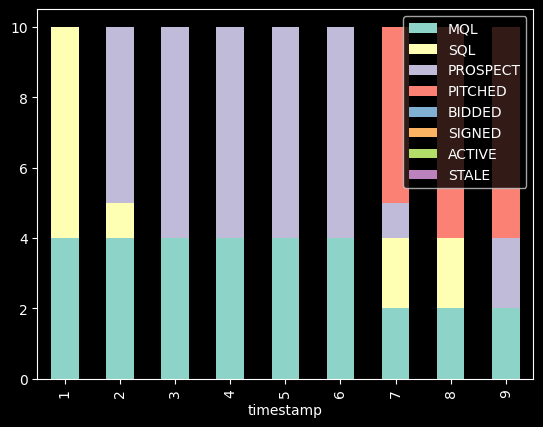

In [36]:
pd.DataFrame(data = env.account_stats).drop(columns=['LEAD', 'nb_accounts']).set_index('timestamp').plot(kind="bar", stacked=True);

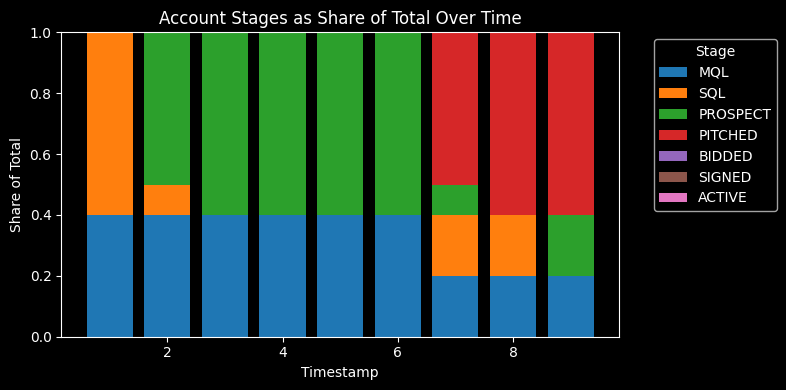

In [37]:
df = pd.DataFrame(data=env.account_stats).drop(columns=['LEAD','STALE', 'nb_accounts']).set_index('timestamp')
df_pct = df.div(df.sum(axis=1), axis=0)  # Normalize to share

# Prepare for stacking
bottom = np.zeros(len(df_pct))
x = df_pct.index
colors = sns.color_palette("tab10", n_colors=len(df_pct.columns))

plt.figure(figsize=(8,4))
for i, col in enumerate(df_pct.columns):
    plt.bar(x, df_pct[col], bottom=bottom, label=col, color=colors[i])
    bottom += df_pct[col].values

plt.xlabel("Timestamp")
plt.ylabel("Share of Total")
plt.title("Account Stages as Share of Total Over Time")
plt.legend(title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [38]:
pd.DataFrame(env.crm_transactions)


,timestamp,initiator,recipient,message,type
0,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-7d5a3cd3-3068-40ea-ad4d-c6f14348345e,NewMQL,Internal
1,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-74fc3944-672a-4f18-84d9-053a8e728358,NewMQL,Internal
2,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-8f724dba-5787-4434-a206-b8217718f32a,NewMQL,Internal
3,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-4caa9618-e146-42fe-8b90-319778c69e8e,NewMQL,Internal
4,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-62bcab4e-2224-4752-9c6e-219da3065591,NewMQL,Internal
...,...,...,...,...,...
123,9.0,srep-93571e6c-9e73-4c84-ba6c-865185738c1e,acct-8f724dba-5787-4434-a206-b8217718f32a,bid submission,External
124,9.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-4caa9618-e146-42fe-8b90-319778c69e8e,email campaign,External
125,9.0,acct-7d5a3cd3-3068-40ea-ad4d-c6f14348345e,srep-d7693581-bb0b-4ccc-aa5c-61a47e75a9ac,user need review,External
126,9.0,acct-74fc3944-672a-4f18-84d9-053a8e728358,srep-632ea9d9-708b-4caa-aa69-db8b3e351bc4,user need review,External


In [39]:
pd.DataFrame(env.crm_transactions)

,timestamp,initiator,recipient,message,type
0,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-7d5a3cd3-3068-40ea-ad4d-c6f14348345e,NewMQL,Internal
1,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-74fc3944-672a-4f18-84d9-053a8e728358,NewMQL,Internal
2,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-8f724dba-5787-4434-a206-b8217718f32a,NewMQL,Internal
3,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-4caa9618-e146-42fe-8b90-319778c69e8e,NewMQL,Internal
4,0.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-62bcab4e-2224-4752-9c6e-219da3065591,NewMQL,Internal
...,...,...,...,...,...
123,9.0,srep-93571e6c-9e73-4c84-ba6c-865185738c1e,acct-8f724dba-5787-4434-a206-b8217718f32a,bid submission,External
124,9.0,mktg-f77232d7-df87-4b56-809c-08cd892be739,acct-4caa9618-e146-42fe-8b90-319778c69e8e,email campaign,External
125,9.0,acct-7d5a3cd3-3068-40ea-ad4d-c6f14348345e,srep-d7693581-bb0b-4ccc-aa5c-61a47e75a9ac,user need review,External
126,9.0,acct-74fc3944-672a-4f18-84d9-053a8e728358,srep-632ea9d9-708b-4caa-aa69-db8b3e351bc4,user need review,External


## CRM Environment

#### Reference Conversion Rates

##### MQL
- website
    - nb mthly website visitor=2900 monthly
    - website cta rate=0.03
- email
    - online campaigns targets=1000 monthly
    - online campaigns clickthru=0.1
- industry event
    - nb industry events=1 quarterly
    - rawleads industry events=80 * nb industry events
- direct calls
    - rawleads salesreps=30 monthly (?)
- conversion 
    - rawlead2mql website=0.41
    - rawlead2mql online campaign=0.38
    - rawlead2mql industry event=0.3
    - salesrep leads2mql=0.02

##### SQL and later stages
- conversion
    - mql2sql=0.15
    - sql2prospect=0.7
    - prospect2prez=0.7
    - prez2bid=0.6
    - bid2close=0.3
    - customer satisfaction rate=0.98

- delays
    - mql2sql= 1 to 2 weeks
    - sql2prospect= 1 to 2 weeks
    - prospect2prez= 1 to 4 weeks
    - prez2bid= 2 to 12 weeks
    - bid2close= 2 to 12 weeks
    - customer project duration = 12 to 24 weeks


- decay rate=0.15

Using the class `CustomerRelationManagerSimulator`

In [40]:
crm = CustomerRelationManagerSimulator(nb_salesreps=5, nb_mql_accounts=20, nb_sql_accounts=20)
len(crm.env.sales_reps),len(crm.env.accounts)

Created 20 MQL accounts
Created 20 SQL accounts


(5, 40)

In [41]:
# crm.iterate()
crm.run(until=50)

[0.00] Marketing: Found 20 MQL accounts
[0.00] Marketing: 3 accounts targetted for email campaign
[0.00] SalesRep 1: sql: 0, []
1
[0.00] SalesRep 1: accts: 0, []
[0.00] SalesRep 1: prospects: 0, []
[0.00] SalesRep 1: prospects: 0, []
[0.00] SalesRep 2: sql: 0, []
1
[0.00] SalesRep 2: accts: 0, []
[0.00] SalesRep 2: prospects: 0, []
[0.00] SalesRep 2: prospects: 0, []
[0.00] SalesRep 3: sql: 0, []
1
[0.00] SalesRep 3: accts: 0, []
[0.00] SalesRep 3: prospects: 0, []
[0.00] SalesRep 3: prospects: 0, []
[0.00] SalesRep 4: sql: 0, []
1
[0.00] SalesRep 4: accts: 0, []
[0.00] SalesRep 4: prospects: 0, []
[0.00] SalesRep 4: prospects: 0, []
[0.00] SalesRep 5: sql: 0, []
1
[0.00] SalesRep 5: accts: 0, []
[0.00] SalesRep 5: prospects: 0, []
[0.00] SalesRep 5: prospects: 0, []
[0.00] Marketing: Sent email targeting HanoiFlex Co., Ltd.
[0.00] HanoiFlex Co., Ltd.: HanoiFlex Co., Ltd. received message: email campaign
[0.00] Marketing: Sent email targeting KielcePak Sp. z o.o.
[0.00] KielcePak Sp. z

In [ ]:
crm.get_account_stats()

,timestamp,nb_accounts,LEAD,MQL,SQL,PROSPECT,PITCHED,BIDDED,SIGNED,ACTIVE,STALE
timestamp,,,,,,,,,,,
1,1,43,0,23,20,0,0,0,0,0,0
2,2,44,0,24,20,0,0,0,0,0,0
3,3,48,0,28,20,0,0,0,0,0,0
4,4,50,0,30,20,0,0,0,0,0,0
5,5,53,0,33,20,0,0,0,0,0,0
6,6,56,0,36,20,0,0,0,0,0,0
7,7,60,0,40,20,0,0,0,0,0,0
8,8,61,0,41,20,0,0,0,0,0,0
9,9,66,0,46,20,0,0,0,0,0,0


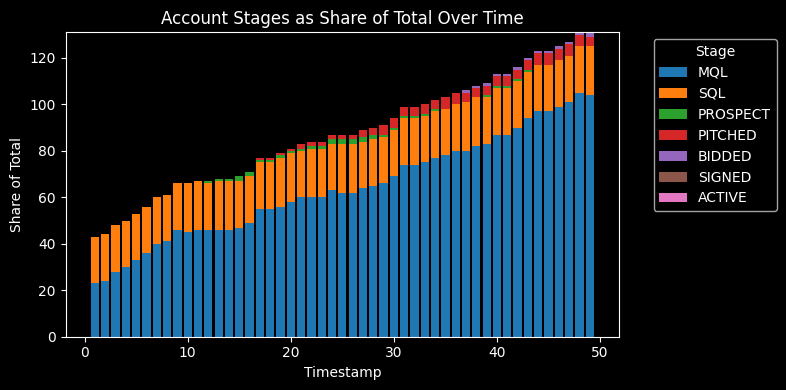

In [43]:
crm.plot_account_stats(as_share=False)

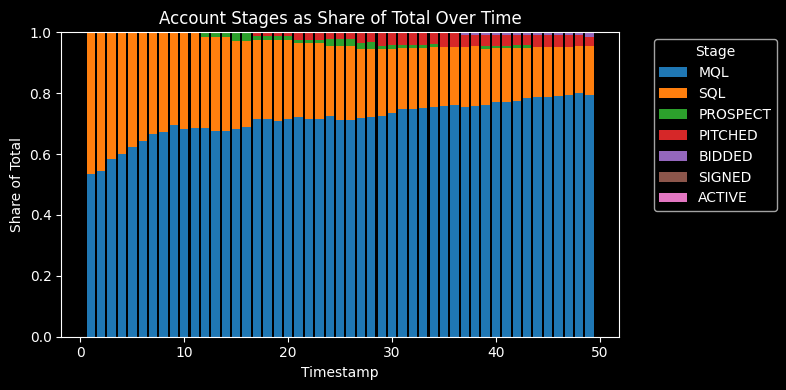

In [44]:
crm.plot_account_stats(as_share=True)

In [122]:
df = crm.get_crm_transactions()
df

,timestamp,initiator,recipient,message,type
0,0.000000,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-6eaadefb-7e47-4f71-8644-65d70c6cd403,NewMQL,Internal
1,0.000000,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-c4fcc35b-8a80-49fb-9774-e59cd98353ac,NewMQL,Internal
2,0.000000,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-a2c37f74-e1dd-41ef-8527-5bd52c2fc219,NewMQL,Internal
3,0.000000,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-85362243-c8f9-4353-be6a-6eadcf65c1a1,NewMQL,Internal
4,0.000000,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-6f099519-ef15-48e3-849e-9be809fbc27f,NewMQL,Internal
...,...,...,...,...,...
3794,99.000000,srep-8219c0fa-c1a6-4437-becc-90105a3cd287,acct-95ab7c64-0bd6-45be-8315-b4c88b02628d,SQL2PROSPECT,Internal
3795,99.000000,acct-90eb962b-b6ea-4710-a704-432b2466967b,srep-e1ff414a-be36-40bb-b509-6ee544d38fa6,presentation request,External
3796,99.000000,acct-2f1034a8-3652-42a6-8f44-41602fb69983,srep-e1ff414a-be36-40bb-b509-6ee544d38fa6,user need review,External
3797,99.000000,srep-e1ff414a-be36-40bb-b509-6ee544d38fa6,acct-2f1034a8-3652-42a6-8f44-41602fb69983,SQL2PROSPECT,Internal


In [124]:
internal_df = df.loc[df.loc[:,'type']=='Internal',:]
internal_df.head()

,timestamp,initiator,recipient,message,type
0,0.0,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-6eaadefb-7e47-4f71-8644-65d70c6cd403,NewMQL,Internal
1,0.0,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-c4fcc35b-8a80-49fb-9774-e59cd98353ac,NewMQL,Internal
2,0.0,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-a2c37f74-e1dd-41ef-8527-5bd52c2fc219,NewMQL,Internal
3,0.0,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-85362243-c8f9-4353-be6a-6eadcf65c1a1,NewMQL,Internal
4,0.0,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-6f099519-ef15-48e3-849e-9be809fbc27f,NewMQL,Internal


In [125]:
internal_df.sort_values(by=['recipient','timestamp'], ascending=True)

,timestamp,initiator,recipient,message,type
52,1.058903,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-00cda17e-0df7-43af-91aa-beabb3af8c65,NewMQL,Internal
1500,49.000000,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-00cda17e-0df7-43af-91aa-beabb3af8c65,MQL2SQL,Internal
1570,51.000000,srep-8c412eab-eab9-427d-bf2d-0e8d94e0ab05,acct-00cda17e-0df7-43af-91aa-beabb3af8c65,SQL2PROSPECT,Internal
1812,56.000000,srep-8c412eab-eab9-427d-bf2d-0e8d94e0ab05,acct-00cda17e-0df7-43af-91aa-beabb3af8c65,PROSPECT2PITCHED,Internal
2709,76.000000,srep-8c412eab-eab9-427d-bf2d-0e8d94e0ab05,acct-00cda17e-0df7-43af-91aa-beabb3af8c65,PITCHED2BIDDED,Internal
...,...,...,...,...,...
3211,87.000000,srep-e1ff414a-be36-40bb-b509-6ee544d38fa6,acct-f7d15ef5-0b32-4f46-93c6-e25fdf9e5810,PITCHED2BIDDED,Internal
1414,47.697217,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-f8083e2b-0b7d-464b-80fc-9cbcc1a4f4f2,NewMQL,Internal
75,3.149439,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-f85a989d-dd9d-4e9f-b444-264fbea4c677,NewMQL,Internal
1243,43.776747,mktg-f8432404-3de1-4ca7-a497-baf671f151f0,acct-fc843403-e706-4efa-938b-242e40a61c2b,NewMQL,Internal


In [20]:
internal_df.sort_values(by=['timestamp'], ascending=True)

,timestamp,initiator,recipient,message,type
0,0.000000,mktg-476510fd-8c78-4f4e-9e5d-b75279a5b4be,acct-e04131ec-ffc1-451b-a049-144ff270511b,NewMQL,Internal
1,0.000000,mktg-476510fd-8c78-4f4e-9e5d-b75279a5b4be,acct-1de3c188-9dbd-457b-b571-19d46a4e504f,NewMQL,Internal
2,0.000000,mktg-476510fd-8c78-4f4e-9e5d-b75279a5b4be,acct-4011ef94-a388-4067-8af3-c474272aea8b,NewMQL,Internal
3,0.000000,mktg-476510fd-8c78-4f4e-9e5d-b75279a5b4be,acct-b969c236-0a11-4a85-9fd8-240622ac4f38,NewMQL,Internal
4,0.000000,mktg-476510fd-8c78-4f4e-9e5d-b75279a5b4be,acct-9c91222a-fd13-4dbe-ae40-3b96017948fb,NewMQL,Internal
...,...,...,...,...,...
528,49.000000,mktg-476510fd-8c78-4f4e-9e5d-b75279a5b4be,acct-0ea0a634-1be0-4ca3-9b3c-c1df082114aa,MQL2SQL,Internal
530,49.000000,mktg-476510fd-8c78-4f4e-9e5d-b75279a5b4be,acct-a5625b07-0a67-4cdf-9393-ea74193f370b,MQL2SQL,Internal
531,49.224745,mktg-476510fd-8c78-4f4e-9e5d-b75279a5b4be,acct-8cdeb525-6e6d-4fe3-9527-9529494926c2,NewMQL,Internal
532,49.415698,mktg-476510fd-8c78-4f4e-9e5d-b75279a5b4be,acct-0de2c25a-dcda-4391-9d32-b913f9bb5c8b,NewMQL,Internal


# Sandbox

## Correct Countries, Industries

In [332]:
df = pd.read_csv(Path('../data/account-info.tsv'), sep='\t')

df.loc[:, 'Industry'].unique().tolist()

['Food & Beverage',
 'Consumer Goods',
 'Pharmaceuticals',
 'Industrial Manufacturing',
 'Chemicals',
 'Electronics',
 'Automotive Parts',
 'Packaging Equipment']

In [333]:
mapindustry = {
    'Food & Beverage': Industry.FoodnBeverage.name,
    'Consumer Goods': Industry.ConsumerGoods.name,
    'Pharmaceuticals': Industry.Pharmaceuticals.name,
    'Industrial Manufacturing': Industry.IndustrialManufacturing.name,
    'Chemicals': Industry.Chemicals.name,
    'Electronics': Industry.Electronics.name,
    'Automotive Parts': Industry.AutomotiveParts.name,
    'Packaging Equipment': Industry.PackagingSI.name
}

getattr(Industry, 'FoodnBeverage')

<Industry.FoodnBeverage: 1>

In [334]:
df.loc[:,'Industry'] = df.loc[:,'Industry'].map(mapindustry)
df

,Country,Company Name,Industry
0,Germany,EuroPac GmbH,FoodnBeverage
1,France,Alpine Packaging S.A.,ConsumerGoods
2,Italy,PackItalia S.p.A.,Pharmaceuticals
3,Netherlands,DutchFlex BV,IndustrialManufacturing
4,Belgium,Belgipack NV,Chemicals
...,...,...,...
1137,USA,QuantumWrap Inc.,Pharmaceuticals
1138,Germany,WuppertalPack GmbH,IndustrialManufacturing
1139,China,"ChengduFlex Co., Ltd.",Chemicals
1140,USA,ApexPac Solutions LLC,Electronics


In [335]:
df.loc[:, 'Country'].unique().tolist()

['Germany',
 'France',
 'Italy',
 'Netherlands',
 'Belgium',
 'Poland',
 'Czech Republic',
 'China',
 'Vietnam',
 'Malaysia',
 'Canada',
 'USA',
 'UK',
 'Ireland']

In [336]:
mapcountries = {
    'Germany': Country.EU,
    'France': Country.EU,
    'Italy': Country.EU,
    'Netherlands': Country.EU,
    'Belgium': Country.EU,
    'Poland': Country.EU,
    'Czech Republic': Country.EU,
    'China': Country.CN,
    'Vietnam': Country.CN,
    'Malaysia': Country.CN,
    'Canada': Country.CN,
    'USA': Country.US,
    'UK': Country.EU,
    'Ireland': Country.EU,
}

In [338]:
df.loc[:,'Country'] = df.loc[:,'Country'].map(mapcountries)
df

,Country,Company Name,Industry
0,Country.EU,EuroPac GmbH,FoodnBeverage
1,Country.EU,Alpine Packaging S.A.,ConsumerGoods
2,Country.EU,PackItalia S.p.A.,Pharmaceuticals
3,Country.EU,DutchFlex BV,IndustrialManufacturing
4,Country.EU,Belgipack NV,Chemicals
...,...,...,...
1137,Country.US,QuantumWrap Inc.,Pharmaceuticals
1138,Country.EU,WuppertalPack GmbH,IndustrialManufacturing
1139,Country.CN,"ChengduFlex Co., Ltd.",Chemicals
1140,Country.US,ApexPac Solutions LLC,Electronics


In [339]:
df.to_csv(Path('../data/account-info-clean.tsv'), sep='\t', index=False)

## Concept of inbox (store)

In [ ]:
class Account:
    def __init__(self, env, name):
        self.env = env
        self.name = name
        self.inbox = simpy.Store(env)
        self.env.accounts.append(self)

    def run(self):
        while True:
            print(f"{self.env.now}: {self.name} waiting for messages...")
            msg = yield self.inbox.get()
            print(f"{self.env.now}: {self.name} received {msg}")

def mktg_agent(env, account_store, delay=5):
    yield env.timeout(delay)
    yield account_store.put("marketing outreach")
    print(f"{env.now}: Agent sent event to account")


In [ ]:
def report(env):
    print(f"\n--- Report at time {env.now} ---")
    for account in env.accounts:
        print(f"{account.name}: {account.inbox.items}")
    print("-------------------------------\n")

# ... Account class and other functions ...

def periodic_reporter(env, interval):
    # First report at time 1
    yield env.timeout(1)
    report(env)
    while True:
        yield env.timeout(interval)
        report(env)

In [ ]:
env = simpy.Environment()
env.accounts = []  # type: ignore


account1 = Account(env, "A1")
account2 = Account(env, "A2")

env.process(account1.run())
env.process(account2.run())

env.process(mktg_agent(env, account1.inbox, 3))
env.process(mktg_agent(env, account2.inbox))
env.process(periodic_reporter(env, 1))
env.run(until=10)

In [ ]:
print(env.peek())
env.run(env.peek()+1)

In [ ]:
print(env.peek())
env.run(env.peek()+1)

In [ ]:
print(env.peek())
env.run(env.peek()+1)

In [ ]:
print(env.peek())
env.run(env.peek()+1)